# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import seaborn as sns
import os

In [2]:
# f_name = "out/estimate/hsq-0.25-pcausal-0.01-cor-1.0-hermodel-mafukb.estimate.json"

# with open(f_name) as f:
#     data = json.load(f)

#     df_plot = pd.DataFrame(
#         np.array([d["estimate"] for d in data]),
#         columns=[
#             "estimated_var_g",
#             "estimated_rho",
#             "estimated_var_e",
#         ],
#     )
# df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

In [5]:
rls_list = []

for hsq in [0.1, 0.5]:
    for pcausal in [0.01, 0.001, 1.0]:
        for cor in [0.8, 1.0]:
            for hermodel in ["mafukb"]:
                f_name = (
                    f"out/estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                    + f"-hermodel-{hermodel}.estimate.json"
                )
                if not os.path.exists(f_name):
                    continue
                with open(f_name) as f:
                    data = json.load(f)

                    df_tmp = pd.DataFrame(
                        np.array([d["estimate"] for d in data]),
                        columns=[
                            "estimated_var_g",
                            "estimated_rho",
                            "estimated_var_e",
                        ],
                    )
                    df_tmp["hsq"] = hsq
                    df_tmp["cor"] = cor
                    df_tmp["pcausal"] = pcausal
                    df_tmp["hermodel"] = hermodel
                    rls_list.append(df_tmp)

df_plot = pd.concat(rls_list)
df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]
# df_plot.loc[df_plot["estimated_ratio"] < -1, "estimated_ratio"] = 0
# df_plot.loc[df_plot["estimated_ratio"] > 10, "estimated_ratio"] = 1

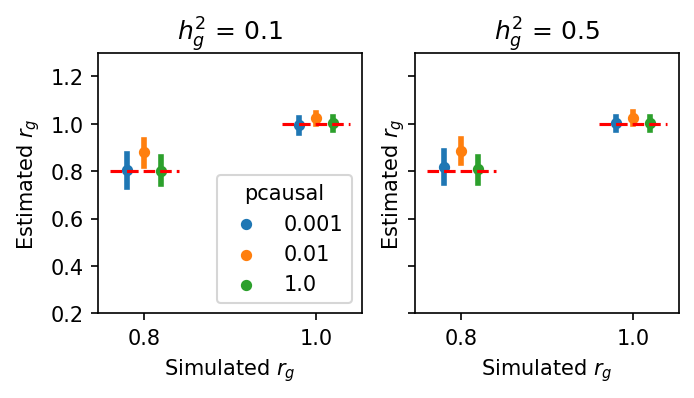

In [6]:
fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=2)

for ax_i, hsq in enumerate([0.1, 0.5]):
    df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

    ax = axes[ax_i]

    sns.pointplot(
        data=df_tmp,
        x="cor",
        y="estimated_ratio",
        hue="pcausal",
        ax=ax,
        markers=".",
        dodge=0.2,
        join=False,
    )
    cor_list = sorted(df_plot.cor.unique())

    ax.hlines(
        cor_list,
        np.arange(len(cor_list)) - 0.2,
        np.arange(len(cor_list)) + 0.2,
        color="red",
        ls="--",
        zorder=10,
    )
    ax.set_ylim(0.2, 1.3)
    ax.set_xlabel("Simulated $r_g$")
    ax.set_ylabel("Estimated $r_g$")
    ax.set_title("$h_g^2$" + f" = {hsq}")
    if ax_i != 0:
        axes[ax_i].legend([], [], frameon=False)

In [94]:
df_plot.sort_values("estimated_var_g")

,estimated_var_g,estimated_rho,estimated_var_e,hsq,cor,pcausal,hermodel,estimated_ratio
79,0.154485,-0.032049,0.956861,0.1,0.8,0.010,mafukb,-0.207460
18,0.174448,0.054460,0.930034,0.1,0.8,0.010,mafukb,0.312183
72,0.204402,0.137262,0.944830,0.1,0.8,1.000,mafukb,0.671530
0,0.207929,0.207149,0.936254,0.1,0.8,0.010,mafukb,0.996253
95,0.211349,0.069582,0.942536,0.1,0.8,0.010,mafukb,0.329230
...,...,...,...,...,...,...,...,...
54,3.441567,0.839028,-0.093613,0.5,0.8,1.000,mafukb,0.243792
68,3.449691,2.572215,0.061967,0.5,1.0,0.010,mafukb,0.745636
0,3.458500,2.242605,0.019432,0.5,1.0,0.001,mafukb,0.648433
77,3.564349,3.052088,0.070298,0.5,1.0,0.001,mafukb,0.856282


In [53]:
df_plot.std()

<ipython-input-53-bd74facbc5a6>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_plot.std()


estimated_var_g    0.858649
estimated_rho      0.845207
estimated_var_e    0.220141
hsq                0.199262
cor                0.099631
pcausal            0.443130
estimated_ratio    4.633225
dtype: float64

In [67]:
sim_i = 47

In [68]:
sim_beta = beta[:, :, sim_i]
sim_beta = sim_beta[np.any(sim_beta != 0, axis=1), :]

In [69]:
np.cov(sim_beta.T)

array([[0.00064561, 0.00054381],
       [0.00054381, 0.00070139]])

In [44]:
sim_beta

array([[-0.00280472, -0.00527307],
       [ 0.00889807,  0.00823082],
       [ 0.00121278,  0.04253152],
       ...,
       [ 0.00188879,  0.01125861],
       [ 0.06872904,  0.04997627],
       [-0.02174921, -0.03172026]])

In [ ]:
beta[:, 0, sim_i]

In [27]:
beta.shape

(1340372, 2, 100)

In [29]:
# rls_list = []

# for simulate_snpset in ["hm3", "imputed"]:
#     for estimate_snpset in ["hm3", "imputed"]:
#         for pcausal in [0.005, 0.1, 1.0]:
#             for rho in [0.5, 0.8, 1.0]:
#                 f_name = f"out/estimate/snpset-{simulate_snpset}-varg-1.0-pcausal-{pcausal}-rho-{rho}.{estimate_snpset}.estimate.json"
#                 if not os.path.exists(f_name):
#                     continue
#                 with open(f_name) as f:
#                     data = json.load(f)
#                     df_tmp = pd.DataFrame(
#                         np.array([d["estimate"] for d in data]),
#                         columns=["estimated_var_g", "estimated_rho", "estimated_var_e"],
#                     )
#                     df_tmp["simulate_snpset"] = simulate_snpset
#                     df_tmp["estimate_snpset"] = estimate_snpset
#                     df_tmp["rho"] = rho
#                     df_tmp["pcausal"] = pcausal
#                     rls_list.append(df_tmp)

# df_plot = pd.concat(rls_list)
# df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]